                                                **PROJET DEEP-LEARNNG**
                                                  
                                                        PROJET 5

                                              **Extraction de Définition**
      

                         Participants :    **YOULA MOHAMED ET GLODY YABADA**

**SOMMAIRE**



1.  Extrction et Prétraitement des données

2.  Classification avec des réseux de neurones 

3.  Optimisation des paramètre du meilleur modèle

4.  Prédiction de la classe d'une instance choisit 

5.  Conclusion 




**IMPORTATION DES LIBRAIRIES** 

In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**TELECHARGEMENT DES DONNEES**

In [2]:
file1 = open('/content/wiki_bad.txt',"r") # Ficher des definition positives  
file2 = open('/content/wiki_good.txt',"r",encoding="utf8")# fichier des definitions négatives  

Dans chacun des fichers téléchargés les définitions étant décrites par deux lignes nous nous interesserons qu'aux premières lignes de ces descriptions. Nous allons donc les extraires et remplacer le caractère 'TARGET' quelles contiennent par le (les) mot(s) situé(s) avant le premier ':' de la secondes descriptions, car 'TARGET' représente ce(s) mot(s) .      

Le code ci-dessous nous permet donc de faire cette oprération.  


In [3]:
# Extraction pour le fichier Wiki_good.txt
wiki_good=[]
line = file2 .readline()
while line:
      wiki_good.append(line)
      line = file2.readline() 
file2.close()

Wiki_good=[]
for i in range(round(len(wiki_good)/2)):
    ch=wiki_good[(2*i)+1]
    [l,r] = ch.split(":", 1)
    t1=wiki_good[2*i].replace("TARGET",l)  
    Wiki_good.append((t1,1))               # affectation de '1' aux lignes extraites du fichier Wiki_good.txt

# Extraction pour le fichier Wiki_bad.txt
wiki_bad=[]
line = file1.readline()
while line:
      wiki_bad.append(line)
      line = file1.readline() 
file1.close()

Wiki_bad=[] 
for i in range(round(len(wiki_bad)/2)):
    ch=wiki_bad[(2*i)+1]
    [l,r] = ch.split(":", 1)
    t1=wiki_bad[2*i].replace("TARGET",l[1:]) 
    Wiki_bad.append((t1,0))                   # affectation de '0' aux lignes extraites du fichier Wiki_bad.txt 


# Assemblage des linges extraites dans un dataframe  
d1=pd.DataFrame(Wiki_good,columns=['CONTENT','CLASS'])
d2=pd.DataFrame(Wiki_bad,columns=['CONTENT','CLASS'])
df=pd.concat([d1,d2])


Nous obtenons donc un Dataframe où la première colone nommée 'CONTENT' contient des phrases et la seconde 'CLASS' est la colone des deux classes à prédire.  

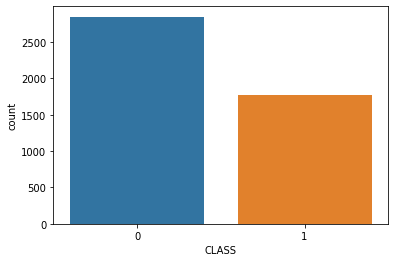

In [4]:
import seaborn as sns
sns.countplot(x='CLASS', data=df)

**PRETRAITEMENT DES DONNEES**

Avant de faire la classification, puisque dans notre dataframe il ya des erreurs de  des sasie, des caractère spéciaux, et autres expresions unitles dans notre travail nous allons effectuer les prétraitements suivants :

1.   Suppression des paranthèses et leur contenu,car la plus part de ces paranthèses contiennent des synonymes des TARGETs.
2.   Suppressions des ponctuations et des nombres, car elles sont très fréquentes dans les deux types de fichier, donc unitiles pour la classification.  
3.   Supressions des espaces multiples, car un espace est un caractère sous python. 
4.   Découper chaque linge de phrases en tocken en les convertissant tous en miniscule. 
5.  Suppression des stop words sauf ceux qui apparaisent le plus souvent dans une définition coomme 'is', 'type', 'an'  par exemple.
6.  Et la lemmatisation des tokens.     


In [5]:
lemma=WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

authers_word=['is','a','was','are','were','refers','of','the','type','kind','an','also']  

def processing(sent):
    sent=re.sub(r'\([^)]*\)', '', sent)
    sent = re.sub('[^a-zA-Z]', ' ', sent)
    sent = re.sub(r'\s+', ' ', sent)    
    tokens=word_tokenize(sent.lower())
    for w in tokens :  
        if w in stop_words and w not in authers_word : 
           tokens.remove(w)        
    tokens=[lemma.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

df['CONTENT']=df.CONTENT.apply(lambda sent:  processing(processing(sent)))
df = shuffle(df)
df.head(5)

,CONTENT,CLASS
49,an amateur refers a person attached a particul...,1
890,tomica later also produced model disney charac...,0
645,factor increase the activity of cefepime other...,0
1891,limited account of proscaline found journal ar...,0
120,adding the protective catshead the gable end o...,0


**CONSTRUCTION DES DONNEES D' APPRENTISSAGE ET DE TEST**

   Dans cette partie nous effectuons les opérations suivantes:

1. construction d'un jeu de données de 80 % des données initiales  pour       l'ensemble d'apprentissage  et 20 % pour l'ensemble test. 
2. Transformation de nos deux jeu de données en matrice en utilisant 5000 mots les plus fréquents du corpus. Avec cet ensemble de mot nous construisons un dictionnaire de mots-index. les différents mots sont alors affectés chacune à une clé unique. Puis nous créons une liste de sous-listes. Chaque sous-liste correspond à une ligne et sont de longeur 50 égale à la dimmention de l'embédding de mots que nous utiliserons dans la suite.Elles auront comme éléments les index associés au mots qu'elles contienent et 0 pour les mots qu'elles ne contiennent pas.         
  

In [6]:
# Construction de l'ensemble test et de l'ensemble d'apprentissage
X = []
sentences = list(df['CONTENT'])
for sen in sentences:
    X.append(sen)
y=np.array(list(df['CLASS']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Tokennisation des contenus textuelle des deux ensembles
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Transformation de l'ensemble train et l'ensemble test en matrice à contenue numérique
vocab_size = len(tokenizer.word_index) + 1
maxlen = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

**EMBEDDING DE MOTS (GloVe)**

Nous construisons aussi une matrice à partire d'un embédding de mots préentrainé de type Glove qui est basé sur des techniques de factorisation de matrices mot-contexte. cette matrice contient 14569 lignes qui corespondent chacune au unique mots du corpus et est dimension 50.    


In [7]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.50d.txt', encoding="utf8") # nous téléchargeons l'embédding de mots (GloVe) préentrainé de dimention 50
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape       

(14412, 50)

La matrice obtenue ci-dessus nous permetra  donc de construre un couche d'embedding pour les réseaux de neurones que nous évaluerons dans la suite. 

**CLASSIFICATION AVEC UN RESEAU DE NEURONE SIMPLE**

Dans le code ci dessous nous créons un modèle séquentiel.

Puis, nous créons une couche d'embédding dont l'input et l'output sont de longeur 50.la Talle du vocabulare est 720750.

Nous utlisons comme foction d'activation pour la couche de sortie de ce modèle la fonction sigmoide.

Et pout son evaluation nous utlison l'optimiser adam , binary_crossentropy pour la foction de perte et l'acurracy pour la metrique.  

In [8]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            720600    
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2501      
Total params: 723,101
Trainable params: 2,501
Non-trainable params: 720,600
_________________________________________________________________
None


Avec le nombre d'instance (batch_size) fixé à 128 pour la mise à jour des poids et le nombre d'époche fixé à 50 nous obtenons les résultats suivants :

In [9]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
24/24 [==============================] - 1s 30ms/step - loss: 0.7098 - acc: 0.5101 - val_loss: 0.6113 - val_acc: 0.6698
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.5660 - acc: 0.7254 - val_loss: 0.5397 - val_acc: 0.7564
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.5057 - acc: 0.7891 - val_loss: 0.4970 - val_acc: 0.7903
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.4640 - acc: 0.8115 - val_loss: 0.4704 - val_acc: 0.8092
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.4307 - acc: 0.8347 - val_loss: 0.4495 - val_acc: 0.8227
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 0.4039 - acc: 0.8536 - val_loss: 0.4383 - val_acc: 0.8214
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.3931 - acc: 0.8463 - val_loss: 0.4234 - val_acc: 0.8295
Epoch 8/50
24/24 [==============================] - 0s 4ms/step - loss: 0.3628 - acc: 0.8

Ci-dessous nous calculons la moyenne des écarts pour détecter l'overfiting:   

In [10]:
# Moyenne des écarts entre les Accurracies sur les données d'apprentissage et Les Accurracies sur les données de validation

def Ecart_Moy(L1,L2): #definition de la fonction pour  moyenne des écats
  S=[]
  for i in range(len(L1)):
      S.append(abs(L1[i]-L2[i]))
  print(sum(S)/len(L1))

L1=history.history['acc']
L2=history.history['val_acc']
Ecart_Moy(L1,L2)

0.06035858750343323


Loss et Accurracy du modèle sur l'ensemble test:  

In [11]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss", score[0])
print("Test Accuracy:", score[1])

29/29 [==============================] - 0s 1ms/step - loss: 0.4030 - acc: 0.8084
Test Loss 0.4030126929283142
Test Accuracy: 0.8084415793418884


À la fin de l'apprentissage , on observe que la moyenne de ecarts entre acurray est autour de 0,08.  

D'autre part nous avons l'accuracy de ce modèle sur l'ensemble test qui vaut 83 %.Ce poucentage aussi nous permetra de comparer ce model aux autre modèles que nous évaluerons dans la suite.           

L'écart observé est aussi visible sur les deux graphiques ci dessous.

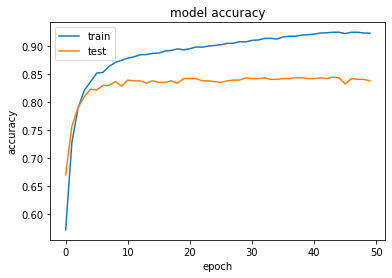

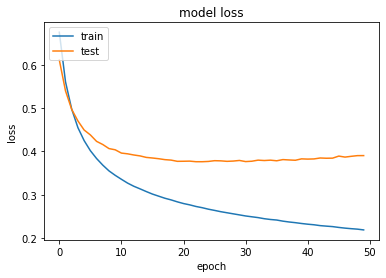

In [12]:
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Les deux courbes divergent sur les deux figures.nous avons donc la présence de l'overfiting.


**CLASSIFICATION AVEC UN RESEAU DE NEURONE CONVOLUTIF**

Dans le code ci dessous nous créons un modèle séquentiel.

Puis, nous créons une couche d'embédding dont l'input et l'output sont de longeur 50.la Talle du vocabulare est 720750.

Nous créons ensuite un réseau de neurone covolutionnel à 1-Dimention dont le  nobre de kernels est 128. La fonction d'activation utilisée à ce niveau est 'rélu'. 

Nous ajoutons aussi une couche pour réduire la taille des features.

Nous utlisons comme fonction d'activation pour la couche de sortie de ce modèle la fonction sigmoide.

Et pout son evaluation nous utlison l'optimiser adam , binary_crossentropy pour la foction de perte et l'acurracy pour la métrique.

In [13]:
from keras.layers.convolutional import Conv1D 
model = Sequential()

embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            720600    
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 752,857
Trainable params: 32,257
Non-trainable params: 720,600
_________________________________________________________________
None


Avec le nombre d'instance (batch_size) fixé à 128 pour la mise à jour des poids et le nombre d'époche fixé à 50 nous obtenons les résultats suivants :



In [14]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)


Epoch 1/50
24/24 [==============================] - 1s 37ms/step - loss: 0.6252 - acc: 0.6354 - val_loss: 0.4925 - val_acc: 0.7781
Epoch 2/50
24/24 [==============================] - 1s 30ms/step - loss: 0.4559 - acc: 0.8003 - val_loss: 0.4241 - val_acc: 0.8119
Epoch 3/50
24/24 [==============================] - 1s 29ms/step - loss: 0.3822 - acc: 0.8500 - val_loss: 0.3824 - val_acc: 0.8268
Epoch 4/50
24/24 [==============================] - 1s 29ms/step - loss: 0.3177 - acc: 0.8847 - val_loss: 0.3593 - val_acc: 0.8376
Epoch 5/50
24/24 [==============================] - 1s 29ms/step - loss: 0.2836 - acc: 0.8962 - val_loss: 0.3412 - val_acc: 0.8525
Epoch 6/50
24/24 [==============================] - 1s 29ms/step - loss: 0.2533 - acc: 0.9182 - val_loss: 0.3292 - val_acc: 0.8660
Epoch 7/50
24/24 [==============================] - 1s 30ms/step - loss: 0.2275 - acc: 0.9297 - val_loss: 0.3193 - val_acc: 0.8769
Epoch 8/50
24/24 [==============================] - 1s 29ms/step - loss: 0.1974 - a

Ci-dessous nous calculons la moyenne des écarts pour détecter l'overfiting:

In [15]:
# Moyenne des écarts entre les Accurracies sur les données d'apprentissage et Les Accurracies sur les données de validation
L1=history.history['acc']
L2=history.history['val_acc']
Ecart_Moy(L1,L2)

0.1012449324131012


Loss et Accurracy du modèle CNN sur l'ensemble test:

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

29/29 [==============================] - 0s 3ms/step - loss: 0.3670 - acc: 0.8647
Test Loss: 0.3670016825199127
Test Accuracy: 0.8647186160087585


Après l'apprentissage , nous avont que la moyenne des ecarts entre accurray pour ce modèle est supérieur à celui du modèle précédent d'où la présence de l'overfiting.

A part la présence de l'overfiting, ce model qui procède par la réduction des features, à quand même une performance supérieure à celle du modèle précédent sur l'ensemble test. Son accuracy 87% sur cet ensemble étant supérieur à celui du modèle précedant 83 %.    

L'écart observé est aussi visible sur les deux graphiques ci dessous.

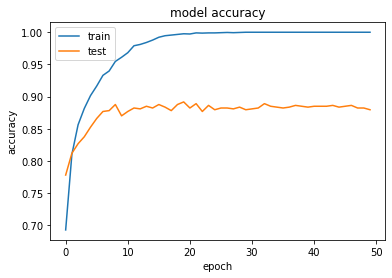

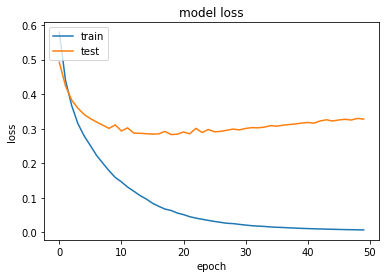

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

**CLASSIFICATION AVEC LSTM**

Comme précédemment nous créons un modèle séquentiel avec une couche d'embédding. 

Puis, nous créons une couche LSTM dont le nombre de neurones est 128.  

Nous utlisons comme fonction d'activation pour la couche de sortie de ce modèle la fonction sigmoide.

Et pout son évaluation nous utlison l'optimiser adam , binary_crossentropy pour la foction de perte et l'acurracy pour la métrique.

In [18]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            720600    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 812,377
Trainable params: 91,777
Non-trainable params: 720,600
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)


Epoch 1/50
24/24 [==============================] - 6s 177ms/step - loss: 0.6757 - acc: 0.6113 - val_loss: 0.5830 - val_acc: 0.7442
Epoch 2/50
24/24 [==============================] - 4s 153ms/step - loss: 0.5842 - acc: 0.7345 - val_loss: 0.4616 - val_acc: 0.8119
Epoch 3/50
24/24 [==============================] - 4s 151ms/step - loss: 0.4414 - acc: 0.8313 - val_loss: 0.4859 - val_acc: 0.8092
Epoch 4/50
24/24 [==============================] - 4s 148ms/step - loss: 0.4703 - acc: 0.8121 - val_loss: 0.4955 - val_acc: 0.7605
Epoch 5/50
24/24 [==============================] - 4s 149ms/step - loss: 0.4608 - acc: 0.7983 - val_loss: 0.5662 - val_acc: 0.7767
Epoch 6/50
24/24 [==============================] - 4s 149ms/step - loss: 0.4936 - acc: 0.8131 - val_loss: 0.5192 - val_acc: 0.7957
Epoch 7/50
24/24 [==============================] - 4s 149ms/step - loss: 0.4629 - acc: 0.8232 - val_loss: 0.4631 - val_acc: 0.8309
Epoch 8/50
24/24 [==============================] - 4s 149ms/step - loss: 0.

Moyenne des écarts pour le modèle LSTM

In [27]:
# Moyenne des écarts entre les Accurracies sur les données d'apprentissage et Les Accurracies sur les données de validation

L1=history.history['acc']
L2=history.history['val_acc']
Ecart_Moy(L1,L2)

0.059181318283081055


Loss et Accurracy du modèle LSTM sur l'ensemble test:

In [28]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

29/29 [==============================] - 0s 16ms/step - loss: 0.4331 - acc: 0.8755
Test Loss: 0.43314090371131897
Test Accuracy: 0.8755411505699158


Comparativement aux deux premiers modèles on voit que ce LSTM a la plus petite  moyenne de écarts entre Acurracies, d'où la réduction de l'overfiting.

Aussi concernant la perfermance sur l'ensemble test il aussi meilleur, car son accurracy sur cet ensemble est 89 %  est supérieur à celui des deux modèle précédents.

Les deux Graphiques ci-dessous nous indique bien que l'ecart pour ce modèle est plus petit.  

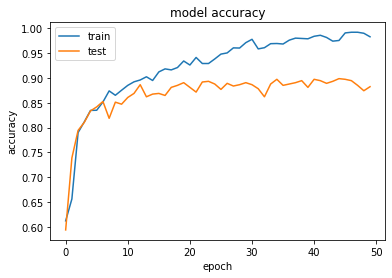

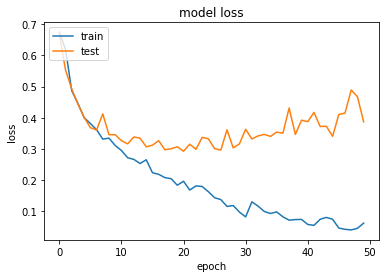

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Comparativement aux graphiques obtenus à patir des modèles précédents,les courbes sont plus proches sur ces deux graphiques du modèle LSTM.  





**OPTIMISATION DES PARAMETRES DU MODEL LSTM**

Nous voulons à présent trouver le nombre d'instance à utiliser pour la mise à jour des poids et le nombre de noeud pour LSTM qui, simultanément, maximisent l'acurracy sur lest données de validation.

In [30]:
# Préparation de l'essemble test, train et celui du développement 
def train_dev_test_split(features_data,labels_data,test_size):
    X_train, X_test, y_train, y_test = train_test_split(features_data,labels_data, test_size=test_size, random_state=42)    
    dev_size=0.5
    X_Dev,X_test2,y_dev,y_test2= train_test_split(X_test,y_test,test_size=dev_size,random_state=42)
    return [X_train,y_train,X_Dev,y_dev,X_test2,y_test2]

Splits=train_dev_test_split(X_train,y_train,0.02)

X_tr=Splits[0]
Y_tr=Splits[1]
X_d=Splits[2]
Y_d=Splits[3]
X_ts=Splits[4]
Y_ts=Splits[5] 


Le code ci-desous nous permet de trouver les valeurs optimales des deux paramètres pour deux listes de valeurs données.

In [31]:


nb_neud=[6,10,128]
batch_size=[64,128,200]
def Parametres_Optimiser(i,batch_size,X_train,y_train,X_dev,y_dev):    
        model_LSTM_2= Sequential()
        embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
        model_LSTM_2.add(embedding_layer) 
        model_LSTM_2.add(LSTM(i))
        model_LSTM_2.add(Dense(1, activation='sigmoid'))
        model_LSTM_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
        
        l=[]
        for j in batch_size:
            model_LSTM_2.fit(X_train, y_train, batch_size=j, epochs=6, verbose=1, validation_split=0.2)
            score=model_LSTM_2.evaluate(X_dev, y_dev, verbose=1)
            l.append([(i,j),score[1]])
        return l
M=[]
for i in nb_neud:
    M.append(Parametres_Optimiser(i,batch_size,X_tr,Y_tr,X_d,Y_d))
    

Epoch 1/6
46/46 [==============================] - 3s 34ms/step - loss: 0.6890 - acc: 0.5779 - val_loss: 0.6658 - val_acc: 0.6331
Epoch 2/6
46/46 [==============================] - 1s 23ms/step - loss: 0.6690 - acc: 0.6132 - val_loss: 0.6580 - val_acc: 0.6331
Epoch 3/6
46/46 [==============================] - 1s 30ms/step - loss: 0.6653 - acc: 0.6182 - val_loss: 0.6580 - val_acc: 0.6331
Epoch 4/6
46/46 [==============================] - 1s 23ms/step - loss: 0.6631 - acc: 0.6212 - val_loss: 0.6556 - val_acc: 0.6331
Epoch 5/6
46/46 [==============================] - 1s 25ms/step - loss: 0.6567 - acc: 0.6145 - val_loss: 0.5978 - val_acc: 0.7021
Epoch 6/6
2/2 [==============================] - 0s 11ms/step - loss: 0.6078 - acc: 0.6486
Epoch 1/6
23/23 [==============================] - 1s 30ms/step - loss: 0.5406 - acc: 0.7390 - val_loss: 0.5616 - val_acc: 0.7131
Epoch 2/6
23/23 [==============================] - 1s 28ms/step - loss: 0.5238 - acc: 0.7583 - val_loss: 0.5420 - val_acc: 0.7517

In [32]:
M=np.array(M).reshape(len(nb_neud)*len(batch_size),2)
M=pd.DataFrame(M,columns=['(Nb_neud, batch_size)','Val_Acc'])
M


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


,"(Nb_neud, batch_size)",Val_Acc
0,"(6, 64)",0.648649
1,"(6, 128)",0.702703
2,"(6, 200)",0.675676
3,"(10, 64)",0.648649
4,"(10, 128)",0.675676
5,"(10, 200)",0.648649
6,"(128, 64)",0.567568
7,"(128, 128)",0.837838
8,"(128, 200)",0.72973


Nous obtenons deux couples de valeurs optimales souvent (128, 180) et (128, 200). 

**REEVALUATION DU MODEL LSTM AVEC LES PARAMETTRES OPTIMALS** 

ICI nous évaluons le modèle LSTM le couple (128,200).    

In [24]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            720600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 812,377
Trainable params: 91,777
Non-trainable params: 720,600
_________________________________________________________________
None


In [25]:
history = model.fit(X_train, y_train, batch_size=200, epochs=50, verbose=1, validation_split=0.2)


Epoch 1/50
15/15 [==============================] - 5s 246ms/step - loss: 0.6822 - acc: 0.5862 - val_loss: 0.6711 - val_acc: 0.5940
Epoch 2/50
15/15 [==============================] - 3s 216ms/step - loss: 0.6469 - acc: 0.6270 - val_loss: 0.5533 - val_acc: 0.7388
Epoch 3/50
15/15 [==============================] - 3s 214ms/step - loss: 0.4950 - acc: 0.7872 - val_loss: 0.4927 - val_acc: 0.7943
Epoch 4/50
15/15 [==============================] - 3s 216ms/step - loss: 0.4498 - acc: 0.8174 - val_loss: 0.4437 - val_acc: 0.8106
Epoch 5/50
15/15 [==============================] - 3s 213ms/step - loss: 0.4043 - acc: 0.8378 - val_loss: 0.4015 - val_acc: 0.8336
Epoch 6/50
15/15 [==============================] - 3s 215ms/step - loss: 0.3880 - acc: 0.8337 - val_loss: 0.3683 - val_acc: 0.8417
Epoch 7/50
15/15 [==============================] - 3s 217ms/step - loss: 0.3744 - acc: 0.8414 - val_loss: 0.3605 - val_acc: 0.8525
Epoch 8/50
15/15 [==============================] - 3s 216ms/step - loss: 0.

In [ ]:
L1=history.history['acc']
L2=history.history['val_acc']
Ecart_Moy(L1,L2)

0.10944520115852356


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

29/29 [==============================] - 1s 17ms/step - loss: 0.9655 - acc: 0.8972
Test Loss: 0.9655138850212097
Test Accuracy: 0.8971861600875854


**PREDICTION POUR UNE INSTANCE**

In [ ]:
instance = X[13] # choix d'une instance   
print(instance)
df.head(15)

the bartians along the prussian were conquered the teutonic knight christianized brought newcomer built many town city


,CONTENT,CLASS
598,the flute is a musical instrument of the woodw...,1
693,type of hacker modifies computer performance n...,0
1743,seinen manga is a subset of manga is generally...,1
825,the infantry are a type of soldier are primari...,1
620,a forge is the workplace of a smith a blacksmith,1
265,makimono were taken scenic place enjoy a beaut...,0
1673,differentiates the hotshot an action hero is a...,0
1944,unlike arthropod insect posse leg the abdomen ...,0
523,the ecliptic is the apparent path the sun trac...,1
2402,elementary function is impossible find an anti...,0


Le code ci-dessous nous permet de prédire à partir du dernier modèl LSTM la class de de cette instance. 

In [ ]:
instance = tokenizer.texts_to_sequences(instance)
L = []
for I in instance:
    for i in I:
        L.append(i)
L = [L]
instance = pad_sequences(L, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.9092474]], dtype=float32)

Comme la fonction d'activation est sigmoid, si on obtient une valeur supérieur à 0.5  c'est la classe 1 qui est prédite si on obtient une valeur inférieur à 0.5 c'est la classe 0 qui est prédite.      

**CONCLUSION** 

Dans ce projet après avoir effectué les prétraitements et l'évaluation de trois types réseau de neurones nous avons vu que le meilleur est LSTM car il est les 
plus adapté pour ce type de tâche.   



